In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

In [3]:
!pip install datasets

In [4]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset from Hugging Face https://huggingface.co/datasets/uoft-cs/cifar10
dataset_cifar10 = load_dataset('cifar10')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
dataset_cifar10

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

array([[[178, 176, 189],
        [178, 176, 189],
        [178, 176, 189],
        ...,
        [170, 168, 180],
        [168, 166, 177],
        [165, 163, 174]],

       [[180, 178, 191],
        [179, 177, 190],
        [180, 178, 191],
        ...,
        [173, 171, 182],
        [171, 169, 180],
        [168, 166, 177]],

       [[177, 175, 188],
        [177, 175, 188],
        [178, 176, 189],
        ...,
        [171, 169, 180],
        [169, 167, 178],
        [167, 165, 176]],

       ...,

       [[112, 107, 107],
        [113, 109, 108],
        [114, 110, 110],
        ...,
        [100,  97,  94],
        [ 98,  94,  93],
        [101,  95,  95]],

       [[112, 102, 101],
        [112, 103, 102],
        [113, 103, 103],
        ...,
        [102,  95,  93],
        [102,  93,  91],
        [102,  92,  91]],

       [[103,  96,  92],
        [100,  93,  90],
        [103,  95,  94],
        ...,
        [ 92,  84,  80],
        [ 93,  86,  80],
        [ 91,  84,  77]]], dtype=uint8)
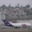

In [21]:
np.array(train_set[0]['img'])

y = 1


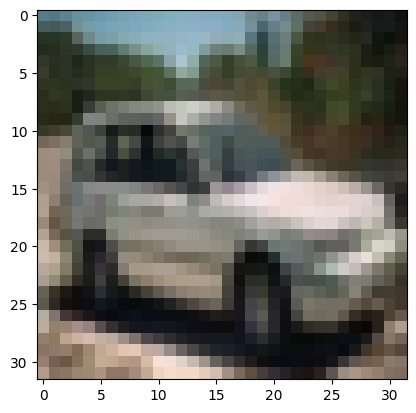

In [53]:
# Access the training and test sets
train_set = dataset_cifar10['train']
test_set = dataset_cifar10['test']

# Convert the data into numpy arrays for consistency with your original code
train_set_x_orig = np.stack([np.array(item['img']) for item in train_set])
train_set_y = np.array([item['label'] for item in train_set])

test_set_x_orig = np.stack([np.array(item['img']) for item in test_set])
test_set_y = np.array([item['label'] for item in test_set])

# Example of a picture
index = 24
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[index]))

In [54]:
train_set_x_orig.shape

(50000, 32, 32, 3)

In [55]:
len(train_set_y)

50000

In [56]:
# prompt: data transformation Reshape the training and test data ((50000, 32, 32, 3)) sets so that images are flattened into single vectors ((5000,32*32*3))

# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (3072, 50000)
train_set_y shape: (50000,)
test_set_x_flatten shape: (3072, 10000)
test_set_y shape: (10000,)
sanity check after reshaping: [178 176 189 178 176]


In [57]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [58]:
# filter the data to keep only label 0 and 1 for the classification problem
train_set_x = train_set_x[:, train_set_y <= 1]
train_set_y = train_set_y[train_set_y <= 1]

In [59]:
# same for test
test_set_x = test_set_x[:, test_set_y <= 1]
test_set_y = test_set_y[test_set_y <= 1]

In [60]:
train_set_x.shape

(3072, 10000)

In [63]:
# form train_set_x keep 10% for train and 10% for validation

new_size = int(train_set_x.shape[1] * 0.1)
# 10% for validation
validation_set_x = train_set_x[:, new_size:2*new_size]
validation_set_y = train_set_y[new_size:2*new_size]

# 10% for training
train_set_x = train_set_x[:, :new_size]
train_set_y = train_set_y[:new_size]

In [64]:
validation_set_x.shape


(3072, 1000)

In [41]:
train_set_x.shape

(3072, 1000)

In [16]:
train_set_y.shape

(1000,)

In [42]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

In [69]:
# init your weights and variables
w_it=np.random.rand(train_set_x.shape[0],1)*0.01
b_it=0
cost_values = []
accuracy_values = []
cost_values_validation = []
accuracy_values_validation = []
alpha = 0.01

In [45]:
def forward(w, b, X, Y):
  Z = np.dot(w.T, X) + b
  A = sigmoid(Z)
  m=X.shape[1]
  cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
  return A, cost

In [46]:
def backward(w, b, X, Y, A):
  m = X.shape[1]  # number of examples
  delta_w = np.dot(X, (A - Y).T) / m
  delta_b = np.sum(A - Y) / m
  new_w = w - alpha * delta_w
  new_b = b - alpha * delta_b
  return new_w, new_b

In [ ]:
#forward(w_it, b_it, train_set_x, train_set_y)

In [70]:
# run a loop of 100 steps using backward and forward and plot the cost function
for i in range(1000):
  predictions, cost = forward(w_it, b_it, train_set_x, train_set_y)
  predictions_validation, cost_validation = forward(w_it, b_it, validation_set_x, validation_set_y)
  cost_values.append(cost)
  cost_values_validation.append(cost_validation)
  accuracy_values.append( np.mean((predictions >= 0.5) == train_set_y))
  accuracy_values_validation.append( np.mean((predictions_validation >= 0.5) == validation_set_y))
  w_it, b_it = backward(w_it, b_it, train_set_x, train_set_y, predictions)

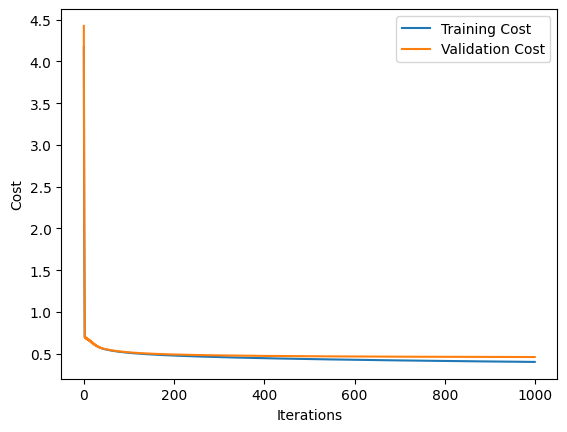

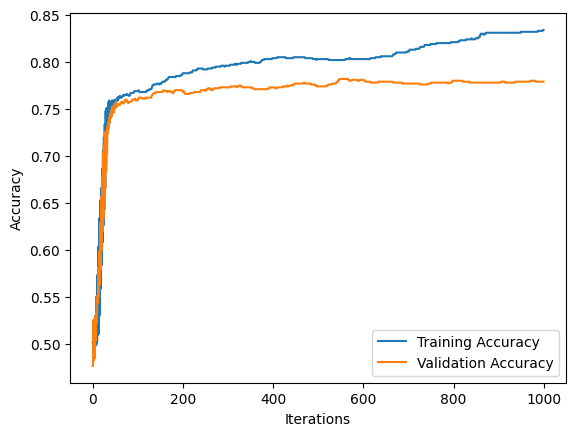

In [71]:
#plot cost_values and cost_values_validation
plt.plot(cost_values, label='Training Cost')
plt.plot(cost_values_validation, label='Validation Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

#plot accuracy_values and accuracy_values_validation
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(accuracy_values_validation, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [72]:
# prompt: compute accuracy on test dataset

# Convert probabilities to class labels (0 or 1)
predictions = forward(w_it, b_it, test_set_x, test_set_y)[0]
predictions_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predictions_labels == test_set_y)
print(f"Accuracy on test dataset: {accuracy}")

Accuracy on test dataset: 0.7855
